In [3]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [4]:
import os; import pandas as pd; import numpy  as np
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from IPython.display import IFrame
def swish(x): return (K.sigmoid(x) * x)

import seaborn as sns
sns.set(style='white', font_scale=1.3, rc={
    'lines.linewidth': 4,
    'axes.grid': True, 'grid.linestyle': ':',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'axes.edgecolor': '.5',
})

In [5]:
# Set the Random Seed
import random


seed_value = 2020

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [9]:
msg_files = glob("MSFT/*message*.csv")
lob_files = glob("MSFT/*order*.csv")
d0 = datetime(2018,1,4)

In [10]:
dfs = []
for day, file in enumerate(np.sort(msg_files)[:]):
    te = pd.read_csv(file, header=None, low_memory=False)
    te['Day'] = d0 + BDay(day)
    dfs.append(te)
df_msg = pd.concat(dfs)

print("{0:0.2f} million observations".format(len(df_msg)/10**6))
df_msg.columns = ['Time', 'Event', 'ID', 'Size', 'Price', 'Direction', '?', 'Day']
df_msg = df_msg.drop(['?'], axis=1)
df_msg['Execution'] = np.where(df_msg['Event'].isin([4,5]), 1, 0)
df_msg.head()

28.98 million observations


,Time,Event,ID,Size,Price,Direction,Day,Execution
0,34200.003224,5,0,374,904700,1,2018-01-04,1
1,34200.006089,4,4003143,311,904800,-1,2018-01-04,1
2,34200.007640,5,0,26,904700,1,2018-01-04,1
3,34200.007640,5,0,74,904700,1,2018-01-04,1
4,34200.051251,1,4056323,1095,905300,-1,2018-01-04,0


In [11]:
dfs = []
for file in np.sort(lob_files)[:]:
    te = pd.read_csv(file, header=None)
    dfs.append(te)
df_lob  = pd.concat(dfs)
cols = np.ravel([['AP%d'%level, 'AV%d'%level, 'BP%d'%level, 'BV%d'%level] for level in [1,2,3,4,5]])
df_lob.columns = cols
print("{0:0.2f} million observations".format(len(df_lob)/10**6))
df_lob.head()

28.98 million observations


,AP1,AV1,BP1,BV1,AP2,AV2,BP2,BV2,AP3,AV3,BP3,BV3,AP4,AV4,BP4,BV4,AP5,AV5,BP5,BV5
0,904800,4315,904400,374,905200,100,904000,50,905300,1730,903500,100,905600,100,903000,200,907000,100,902500,200
1,904800,4004,904400,374,905200,100,904000,50,905300,1730,903500,100,905600,100,903000,200,907000,100,902500,200
2,904800,4004,904400,374,905200,100,904000,50,905300,1730,903500,100,905600,100,903000,200,907000,100,902500,200
3,904800,4004,904400,374,905200,100,904000,50,905300,1730,903500,100,905600,100,903000,200,907000,100,902500,200
4,904800,4004,904400,374,905200,100,904000,50,905300,2825,903500,100,905600,100,903000,200,907000,100,902500,200


In [ ]:
# Merge the two datasets
df = pd.concat([df_msg, df_lob], axis=1)
df = df[df['Execution']==1]

df['DateTime'] = pd.to_datetime((df['Time']*10**9).astype(int), unit='ns')
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute
df['Second'] = df['DateTime'].dt.second
df['30 Seconds'] = (df['Second'] / 30).astype(int)

In [8]:
df

,Time,Event,ID,Size,Price,Direction,Day,Execution,AP1,AV1,...,BV4,AP5,AV5,BP5,BV5,DateTime,Hour,Minute,Second,30 Seconds
0,34200.003224,5,0,374,904700,1,2020-01-02,1,904800,4315,...,200,907000,100,902500,200,1969-12-31 23:59:57.852516352,23,59,57,1
1,34200.006089,4,4003143,311,904800,-1,2020-01-02,1,904800,4004,...,200,907000,100,902500,200,1969-12-31 23:59:57.852516352,23,59,57,1
2,34200.007640,5,0,26,904700,1,2020-01-02,1,904800,4004,...,200,907000,100,902500,200,1969-12-31 23:59:57.852516352,23,59,57,1
3,34200.007640,5,0,74,904700,1,2020-01-02,1,904800,4004,...,200,907000,100,902500,200,1969-12-31 23:59:57.852516352,23,59,57,1
5,34200.072872,5,0,374,904700,1,2020-01-02,1,904800,4004,...,200,907000,100,902500,200,1969-12-31 23:59:57.852516352,23,59,57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660510,57599.979344,4,248784091,100,935100,1,2020-01-30,1,935800,300,...,31610,936200,7550,934600,46400,1969-12-31 23:59:57.852516352,23,59,57,1
1660516,57599.983326,4,248784251,12261,935100,-1,2020-01-30,1,935100,39,...,31610,935900,1400,934600,46400,1969-12-31 23:59:57.852516352,23,59,57,1
1660517,57599.988457,4,248784251,39,935100,-1,2020-01-30,1,935200,12300,...,31610,936000,11209,934600,46400,1969-12-31 23:59:57.852516352,23,59,57,1
1660518,57599.988457,4,248784255,376,935200,-1,2020-01-30,1,935200,11924,...,31610,936000,11209,934600,46400,1969-12-31 23:59:57.852516352,23,59,57,1


In [9]:
# Re-sample the data every 30 seconds
ds = df.groupby(['Day', 'Hour', 'Minute', '30 Seconds']).mean().sort_index().reset_index()
te = df.groupby(['Day', 'Hour', 'Minute', '30 Seconds'])[['Execution']].sum().sort_index().reset_index()
ds['Execution'] = te['Execution']
print("{0:0,.0f} observations".format(len(ds)))
t0 = str(ds['Day'].min())[:10]
t1 = str(ds['Day'].max())[:10]
print("From {0} to {1}".format(t0,t1))
ds.head()

21 observations
From 2020-01-02 to 2020-01-30


,Day,Hour,Minute,30 Seconds,Time,Event,ID,Size,Price,Direction,...,BV3,AP4,AV4,BP4,BV4,AP5,AV5,BP5,BV5,Second
0,2020-01-02,23,59,1,47152.517267,4.085702,1.984355e+08,105.661866,886701.423711,0.167346,...,873.298324,887087.646395,796.868810,886325.767522,954.791032,887189.107699,779.422641,886224.905777,1002.014748,57.0
1,2020-01-03,23,59,1,45654.850759,4.082780,1.616240e+08,97.863774,890965.829755,0.047859,...,717.378711,891346.495066,803.230920,890583.447988,774.458933,891448.336721,856.265909,890482.675247,805.222089,57.0
2,2020-01-06,23,59,1,46781.036946,4.081259,1.722007e+08,124.447082,903171.557977,0.066738,...,932.872634,903553.179948,1117.629529,902785.233887,1011.765625,903654.438519,1146.472970,902684.223678,1038.793494,57.0
3,2020-01-07,23,59,1,45922.618931,4.080374,1.418080e+08,113.227233,923497.567369,0.115985,...,905.719829,923887.749464,1151.553106,923117.038749,955.698707,923990.151088,1177.516349,923014.321419,997.807156,57.0
4,2020-01-08,23,59,1,48350.479408,4.095314,1.916347e+08,122.159825,908834.754826,0.193101,...,758.463835,909228.291826,750.030967,908450.345567,831.487294,909329.748570,799.506837,908349.789979,913.591694,57.0


In [39]:
cols = np.ravel([['AP%d'%level, 'AV%d'%level, 'BP%d'%level, 'BV%d'%level] for level in [1,2,3]])
pcols= np.ravel([['AP%d'%level, 'BP%d'%level] for level in [1,2,3]])
lob_data=pd.DataFrame(columns=cols)
lob_data=df[cols].copy()

#lob_data.apply(lambda x: (x-x.mean())/x.std())
#lob_data['AP1']=lob_data['AP1']/10000 #lob solo eseguiti
for c in pcols:
    lob_data[c]=lob_data[c]/10000
lob_data.reset_index(drop=True,inplace=True)

In [40]:
lob_data

,AP1,AV1,BP1,BV1,AP2,AV2,BP2,BV2,AP3,AV3,BP3,BV3
0,90.48,4315,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
1,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
2,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
3,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
4,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,2825,90.35,100
...,...,...,...,...,...,...,...,...,...,...,...,...
1248063,93.58,300,93.50,44,93.59,1400,93.49,16644,93.60,11209,93.48,40661
1248064,93.51,39,93.50,44,93.52,12300,93.49,16644,93.56,200,93.48,40661
1248065,93.52,12300,93.50,44,93.56,200,93.49,16644,93.58,100,93.48,40661
1248066,93.52,11924,93.50,44,93.56,200,93.49,16644,93.58,100,93.48,40661


In [41]:
#lob_data=df[cols].copy().reset_index()
import os 
from pathlib import Path
#os.makedirs('C:/Users/macri/Desktop/', exist_ok=True)
filepath=Path('/Users/macri/Desktop/out_1.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
lob_data.to_csv(filepath)

In [6]:
#ld=lob_data.values.tolist()
#filepath=Path('/Users/macri/Desktop/out_1.csv')
lob_data=pd.read_csv('/Users/macri/Desktop/out_1.csv')


In [7]:
lob_data.reset_index(drop=True,inplace=True)
lob_data.drop(['index'], axis=1,inplace=True)

In [8]:
ld=lob_data.values.tolist()

In [9]:
def OF(ld):
    of=np.zeros((len(ld),6))
    for i in range(1,7,2):
        for j in range(1,len(lob_data)):
            #BID
            if ld[j-1][i]>ld[j][i] :
                of[j][i]=ld[j][i]
            elif ld[j-1][i]<ld[j][i]:
                of[j][i]=-1*ld[j][i]
            else :
                of[j][i]=ld[j][i]-ld[j-1][i]
            #ASK
            if ld[j-1][i-1]<ld[j][i-1] :
                of[j][i-1]=ld[j][i-2]
            elif ld[j-1][i-1]>ld[j][i-2]:
                of[j][i-1]=-1*ld[j][i-2]
            else :
                of[j][i-1]=ld[j][i-2]-ld[j-1][i-2]
    return of

In [10]:
a=OF(ld)
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(a, columns=bCols)
of_data

,aOF_1,bOF_1,aOF_2,bOF_2,aOF_3,bOF_3
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,4004.0,-311.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1048570,-1323.0,-1400.0,900.0,300.0,-200.0,500.0
1048571,-100.0,356.0,-1044.0,0.0,0.0,-1510.0
1048572,0.0,300.0,-56.0,237.0,-63.0,1500.0
1048573,732.0,-527.0,227.0,-1523.0,1286.0,0.0


In [11]:
from scipy.stats.mstats import winsorize
dz=of_data.apply(lambda x: (x-x.mean())/x.std())
of1=dz.to_numpy()
#=of_data.to_xarray()
of=winsorize(of1, limits=(0.05, 0.05))
ord_flo=pd.DataFrame(of,columns=['bOF1','aOF1','bOF2','aOF2','bOF3','aOF3'])
ord_flo

,bOF1,aOF1,bOF2,aOF2,bOF3,aOF3
0,-0.139432,-0.020919,-0.088034,-0.005173,-0.132653,0.051854
1,-0.139432,0.723010,-0.390074,-0.005173,-0.132653,0.051854
2,-0.139432,-0.020919,-0.088034,-0.005173,-0.132653,0.051854
3,-0.139432,-0.020919,-0.088034,-0.005173,-0.132653,0.051854
4,-0.139432,-0.020919,-0.088034,-0.005173,-0.132653,0.051854
...,...,...,...,...,...,...
1048570,-0.664797,-0.543032,0.723010,0.212044,-0.395440,0.506511
1048571,-0.247915,0.111847,-0.664797,-0.005173,-0.132653,-0.664797
1048572,-0.139432,0.090963,-0.142421,0.166428,-0.215431,0.723010
1048573,0.654665,-0.217457,0.132426,-0.664797,0.723010,0.051854


In [11]:
#from scipy.stats.mstats import winsorize
#lob_data.apply(lambda x: (x-x.mean())/x.std())
#of1=lob_data.to_numpy()
##=of_data.to_xarray()
#of=winsorize(of1, limits=(0.05, 0.05))
#ord_flo=pd.DataFrame(of,columns=['bOF1','aOF1','bOF2','aOF2','bOF3','aOF3'])
#ord_flo
#
#
#of=winsorize(lob_data, limits=(0.05, 0.05))

In [ ]:
#vcols= np.ravel([['AV%d'%level, 'BV%d'%level] for level in [1,2,3]])
#lob_data_v=pd.DataFrame(columns=vcols)
#lob_data_v=lob_data[vcols].copy()
#lob_data_v

In [ ]:
#bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
#of_data = pd.DataFrame(columns=bCols)
#of_data=lob_data_v.copy()
#od=of_data.values.tolist()
#od

In [87]:
#def OF(lob_data):
#    bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
#    of_data = pd.DataFrame(columns=bCols)
#    vcols= np.ravel([['AV%d'%level, 'BV%d'%level] for level in [1,2,3]])
#    lob_data_v=pd.DataFrame(columns=vcols)
#    lob_data_v=lob_data[vcols].copy()
#    bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
#    of_data = pd.DataFrame(columns=bCols)
#    of_data=lob_data_v.copy()
#    for i in range(1,4):
#        for j in range(1,len(lob_data)):
#           # Bid Order Flow
#            if lob_data.loc[j]['BP{}'.format(i)] > lob_data.loc[j-1]['BP{}'.format(i)]:
#                of_data[j]['bOF_{}'.format(i)] = lob_data.loc[j]['BV{}'.format(i)]
#            elif lob_data.loc[j]['BP{}'.format(i)] < lob_data.loc[j-1]['BP{}'.format(i)]:
#                of_data[j]['bOF_{}'.format(i)] = -1*of_data[j]['bOF_{}'.format(i)]#*lob_data.loc[j,'BV{}'.format(i)]
#            else:
#                of_data[j]['bOF_{}'.format(i)] = lob_data.loc[j]['BV{}'.format(i)] - lob_data.loc[j-1]['BV{}'.format(i)]
#    return of_data

In [20]:
#def makeOF(lob_data):
#    of_data = pd.DataFrame()
#
#    for i in range(1,4):
#
#        of_data['bOF_{}'.format(i)] = [None] * len(lob_data)
#        of_data['aOF_{}'.format(i)] = [None] * len(lob_data)
#
#        for j in range(1,len(lob_data)):
#
#            # Bid Order Flow
#            if lob_data.loc[j,'BP{}'.format(i)] > lob_data.loc[j-1,'BP{}'.format(i)]:
#                of_data['bOF_{}'.format(i)][j] = lob_data.loc[j,'BV{}'.format(i)]
#            elif lob_data.loc[j,'BP{}'.format(i)] < lob_data.loc[j-1,'BP{}'.format(i)]:
#                of_data['bOF_{}'.format(i)][j] = -1*lob_data.loc[j,'BV{}'.format(i)]
#            else:
#                of_data['bOF_{}'.format(i)][j] = lob_data.loc[j,'BV{}'.format(i)] - lob_data.loc[j-1,'BV{}'.format(i)]
#
#            ## Ask Order Flow
#            if lob_data.loc[j,'AP{}'.format(i)] > lob_data.loc[j-1,'AP{}'.format(i)]:
#                of_data['aOF_{}'.format(i)][j] = -1*lob_data.loc[j,'AV{}'.format(i)]
#            elif lob_data.loc[j,'AP{}'.format(i)] < lob_data.loc[j-1,'AP{}'.format(i)]:
#                of_data['aOF_{}'.format(i)][j] = lob_data.loc[j,'AV{}'.format(i)]
#            else:
#                of_data['aOF_{}'.format(i)][j] = lob_data.loc[j,'AV{}'.format(i)] - lob_data.loc[j-1,'AV{}'.format(i)]
#
#    # Add output column to of_data
#    of_data = pd.concat([of_data,lob_data.iloc[:,-1:]],axis=1)
#
#    # Drop first row, which is null
#    of_data = of_data.iloc[1:,:].reset_index(drop=True)
#
#    #model_details['OF']['data'] = of_data
#    of_data=of_data.T[:-1]
#    of_data=of_data.T
#    return of_data

In [12]:
lob_data

,AP1,AV1,BP1,BV1,AP2,AV2,BP2,BV2,AP3,AV3,BP3,BV3
0,90.48,4315,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
1,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
2,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
3,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,1730,90.35,100
4,90.48,4004,90.44,374,90.52,100,90.40,50,90.53,2825,90.35,100
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,94.38,1400,94.36,300,94.39,500,94.35,1623,94.40,1050,94.34,400
1048571,94.37,356,94.36,300,94.38,1510,94.35,1623,94.39,500,94.34,300
1048572,94.37,300,94.36,237,94.38,1500,94.35,1623,94.39,600,94.34,300
1048573,94.37,527,94.35,1523,94.38,1500,94.34,200,94.39,600,94.33,1032


In [72]:
a=lob_data['AP1'].values.tolist()
b=lob_data['BP1'].values.tolist()
m=np.zeros(len(a))
u_d=np.zeros(len(a))
for j in range(1,len(a)):
    m[j-1]=(a[j-1]+b[j-1])/2
for i in range(1,len(a)):
    if m[i-1]>m[i]:#scende il prezzo
        u_d[i-1]=-1
    elif m[i-1]<m[i]:#sale il prezzo
        u_d[i-1]=1
    else:
        u_d[i-1]=0
u_d

array([ 0.,  0.,  0., ..., -1., -1.,  0.])

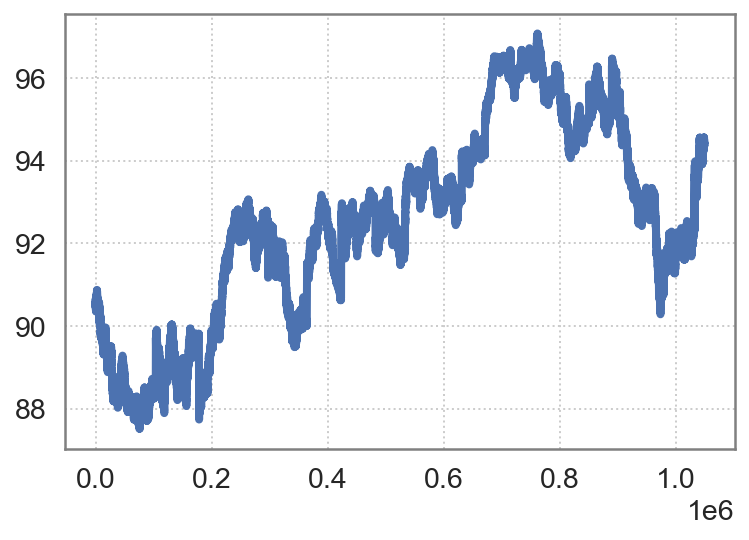

In [76]:
plt.plot(m[:-1])
#plt.plot(u_d)

In [13]:
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

In [14]:
m= midPrice(lob_data)
ud=upDown(m)
ord_flo['ud']=ud

In [15]:
ord_flo

,bOF1,aOF1,bOF2,aOF2,bOF3,aOF3,ud
0,-0.139432,-0.020919,-0.088034,-0.005173,-0.132653,0.051854,0.0
1,-0.139432,0.723010,-0.390074,-0.005173,-0.132653,0.051854,0.0
2,-0.139432,-0.020919,-0.088034,-0.005173,-0.132653,0.051854,0.0
3,-0.139432,-0.020919,-0.088034,-0.005173,-0.132653,0.051854,0.0
4,-0.139432,-0.020919,-0.088034,-0.005173,-0.132653,0.051854,0.0
...,...,...,...,...,...,...,...
1048570,-0.664797,-0.543032,0.723010,0.212044,-0.395440,0.506511,-1.0
1048571,-0.247915,0.111847,-0.664797,-0.005173,-0.132653,-0.664797,0.0
1048572,-0.139432,0.090963,-0.142421,0.166428,-0.215431,0.723010,-1.0
1048573,0.654665,-0.217457,0.132426,-0.664797,0.723010,0.051854,0.0


In [16]:
V = int(len(ord_flo)*0.6)
T = int(len(ord_flo)*0.8)
ds_trai = ord_flo.iloc[ :V].copy()
ds_vali = ord_flo.iloc[V:T].copy()
ds_test = ord_flo.iloc[T: ].copy()
#mp = pd.DataFrame(midPrice(lob_data),columns=['mp'])
#mp_trai = mp.iloc[ :V].copy()
#mp_vali = mp.iloc[V:T].copy()
#mp_test = mp.iloc[T: ].copy()


In [ ]:
#from scipy.stats.mstats import winsorize
#a=of_data.apply(lambda x: (x-x.mean())/x.std())
#of1=a.to_numpy()
##=of_data.to_xarray()
#of=winsorize(of1, limits=(0.05, 0.05))
#ord_flo=pd.DataFrame(of,columns=['bOF1','aOF1','bOF2','aOF2','bOF3','aOF3'])
#ord_flo


#of=winsorize(lob_data, limits=(0.05, 0.05))

In [ ]:
#V = int(len(ord_flo)*0.6)
#T = int(len(ord_flo)*0.8)
#ds_trai = ord_flo.iloc[ :V].copy()
#ds_vali = ord_flo.iloc[V:T].copy()
#ds_test = ord_flo.iloc[T: ].copy()

In [67]:
#MA IO NON VOGLIO IL CATEGORICO QUI IO VOGLIO DEGLI INTERVALLI FUTURI ed y è il midprice
def prepare_x(data):
    df1 = data.to_numpy()[:,:6] 
    return np.array(df1)

def get_label(data):
    lob = data.to_numpy()[:,-1]
    return lob
def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    #y = y[:] - 1
    y = np_utils.to_categorical(y, 3)
    return x, y
#def data_classification(X, Y, T):
#    [N, D] = X.shape
#    df = np.array(X)
#    dY = np.array(Y)
#    dataY = dY[T - 1:N]
#    dataX = np.zeros((N - T + 1, T, D))
#    for i in range(T, N + 1):
#        dataX[i - T] = df[i - T:i][:]
#    return dataX.reshape(dataX.shape + (1,)), dataY
#
#def prepare_x_y(data, mp, k, T):
#    x = prepare_x(data)
#    y = mp#midPrice(lob_data)#MID PRICE QUI get_label(data)
#    x, y = data_classification(x, y, T=T)
#    y = y[:-k]
#    y = np_utils.to_categorical(y.astype(int))
#    return x, y

In [57]:
ds_trai.to_numpy()[:,-1]

array([ 0.,  0.,  0., ...,  0.,  0., -1.])

In [ ]:
mp_trai[:,k] - 1

In [69]:
from keras.utils import np_utils
prepare_x_y(ds_trai, 2, 100)

(array([[[[-0.13943176],
          [-0.02091867],
          [-0.08803427],
          [-0.00517258],
          [-0.13265264],
          [ 0.05185362]],
 
         [[-0.13943176],
          [ 0.72300961],
          [-0.39007446],
          [-0.00517258],
          [-0.13265264],
          [ 0.05185362]],
 
         [[-0.13943176],
          [-0.02091867],
          [-0.08803427],
          [-0.00517258],
          [-0.13265264],
          [ 0.05185362]],
 
         ...,
 
         [[-0.13943176],
          [ 0.01637516],
          [-0.1851533 ],
          [-0.00517258],
          [-0.13265264],
          [ 0.05185362]],
 
         [[-0.13943176],
          [-0.09550633],
          [ 0.00908476],
          [ 0.06723291],
          [-0.26404639],
          [ 0.05185362]],
 
         [[-0.13943176],
          [-0.02091867],
          [-0.08803427],
          [-0.00517258],
          [-0.13265264],
          [ 0.23371656]]],
 
 
        [[[-0.13943176],
          [ 0.72300961],
          [-0

In [70]:
from keras.utils import np_utils





#devi prendere anche lob_data -> split train ecc



k = 4 # which prediction horizon
T = 100 # the length of a single input
n_hiddens = 16
trainX_CNN, trainY_CNN = prepare_x_y(ds_trai, k, T)
valX_CNN, valY_CNN = prepare_x_y(ds_vali, k, T)
testX_CNN, testY_CNN=prepare_x_y(ds_test,k,T)
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(629046, 100, 6, 1) (629046, 3)
(209616, 100, 6, 1) (209616, 3)
(209616, 100, 6, 1) (209616, 3)


In [71]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import LeakyReLU
#from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)


In [149]:

def CNN_LSTM(time_series, lag_param, dropout):
    
    # Convolutions across LOB levels
    if time_series == 'OF':
        input_tensor = Input(shape=(lag_param,20,1))
        #One Spatial Convolution below:
        # Combine imbalance information across sides for each level of the order book
        layer_x = layers.Conv2D(filters=16, kernel_size=(1,2), strides=(1,2))(input_tensor)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
        ######################################################
        #Two Temporal Convolutions below:
        # Combine imbalance information across time for each side and level of the order book
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(layer_x)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(layer_x)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    elif time_series == 'OFI':
        input_tensor = Input(shape=(lag_param,10,1))
        # Combine imbalance information across time for each side and level of the order book
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(input_tensor)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
        layer_x = layers.Conv2D(filters=16, kernel_size=(4,1), padding='same')(layer_x)
        layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    else:
        raise Exception("'time_series' should be 'OF' or 'OFI'")

    # Combine imbalance information across all levels of the book
    layer_x = layers.Conv2D(filters=16, kernel_size=(1,10))(layer_x)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)

    # Inception Module
    # Tower 1
    tower_1 = layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(layer_x)
    tower_1 = layers.LeakyReLU(alpha=0.01)(tower_1)
    tower_1 = layers.Conv2D(filters=32, kernel_size=(3,1), padding='same')(tower_1)
    tower_1 = layers.LeakyReLU(alpha=0.01)(tower_1)
    # Tower 2
    tower_2 = layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(layer_x)
    tower_2 = layers.LeakyReLU(alpha=0.01)(tower_2)
    tower_2 = layers.Conv2D(filters=32, kernel_size=(5,1), padding='same')(tower_2)
    tower_2 = layers.LeakyReLU(alpha=0.01)(tower_2)  
    # Tower 3
    tower_3 = layers.MaxPooling2D(pool_size=(3,1), padding='same', strides=(1,1))(layer_x)
    tower_3 = layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(tower_3)
    tower_3 = layers.LeakyReLU(alpha=0.01)(tower_3)

    # Concatenation and reshaping
    layer_x = layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    layer_x = layers.Reshape(target_shape=(lag_param, 96))(layer_x)
    
    # Insert variational dropout layer
    # By setting training to true, we enable dropout during evaluation passes
    layer_x = layers.Dropout(dropout)(layer_x, training=True)
    
    # LSTM with 64 hidden units
    layer_x = layers.LSTM(units=64)(layer_x)
    
    # Final output layer
    output = layers.Dense(units=3, activation='softmax')(layer_x)
    
    model = Model(input_tensor, output)
    
    opt = Adam(learning_rate=0.01, epsilon=1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [72]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    #conv_first1 = Conv2D(32, (1, 2))(conv_first1)
    #conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    #conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    #conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [73]:
checkpoint_filepath = './model_tensorflow2/weights'

In [74]:
deeplob.compile(  loss='mse',
  optimizer='adam')

In [77]:
%%time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
            epochs=1, batch_size=32, verbose=2, callbacks=[model_checkpoint_callback])


19658/19658 - 3258s - loss: 0.1489 - val_loss: 0.1269 - 3258s/epoch - 166ms/step
Wall time: 54min 35s


In [78]:
deeplob.save(filepath='-CNN-LSTM-SAVED.hdf5',overwrite=True)

In [79]:
deeplob.load_weights(checkpoint_filepath)
pred = deeplob.predict(testX_CNN)

6551/6551 [==============================] - 213s 32ms/step


In [185]:
#deeplob.save(filepath='-CNN-LSTM-SAVED.hdf5',overwrite=True)

In [80]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.6757594840088543
              precision    recall  f1-score   support

           0     0.7471    0.7391    0.7431    113553
           1     0.5878    0.6191    0.6030     47417
           2     0.5993    0.5833    0.5912     48646

    accuracy                         0.6758    209616
   macro avg     0.6447    0.6471    0.6457    209616
weighted avg     0.6768    0.6758    0.6761    209616



In [83]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

TypeError: 'NoneType' object is not subscriptable

In [84]:
from keras.models import load_model
r=load_model('-CNN-LSTM-SAVED.hdf5')
r

In [87]:
pred

array([[0.31047198, 0.13064401, 0.55888397],
       [0.84553844, 0.07514516, 0.07931638],
       [0.93132603, 0.00945383, 0.05922024],
       ...,
       [0.77956474, 0.04843722, 0.17199804],
       [0.30752772, 0.46170813, 0.23076414],
       [0.6091973 , 0.19202358, 0.19877918]], dtype=float32)

In [89]:
from sklearn.metrics import mean_squared_error as mse
t=mse(testY_CNN,pred)
t

0.14667146